<a href="https://colab.research.google.com/github/JIng-Yu-Huang/generative-AI_hw/blob/main/%E6%9C%9F%E6%9C%AB%E5%B0%88%E9%A1%8C_%E7%92%B0%E4%BF%9D%E9%A4%90%E5%BB%B3%E6%8E%A8%E8%96%A6RAG%E7%B3%BB%E7%B5%B1_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **期末專案--基於生成式 AI 與 RAG 技術的環保餐廳推薦系統(6/2更新)🥞**
學號：61308001E  
系級：資教所 碩一  
姓名：黃靖妤  

# **📌專案概述**

我的專案目標在於建立一個「個人化的環保餐廳推薦系統」。  
透過生成式 AI與 RAG 技術，依據使用者需求與喜好，例如餐廳區域或環保作為，自動推薦臺北市政府環境保護局統計的環保餐廳，推薦時會提供詳細且貼心的推薦理由，提升推薦品質。  
使用老師在第八周所教的內容來進行實作！


**專案目標**  

1. 結合臺北市政府資料開放平臺的【臺北市環保餐廳】(資料更新時間為2025.05.24)  
下載網址：https://data.gov.tw/dataset/132379
   
2. 提供個人化推薦（含地區、環保作為）
3. 使用 RAG 技術即時獲取最適合的餐廳資訊
4. 生成自然、具說服力的推薦理由

# **介面**



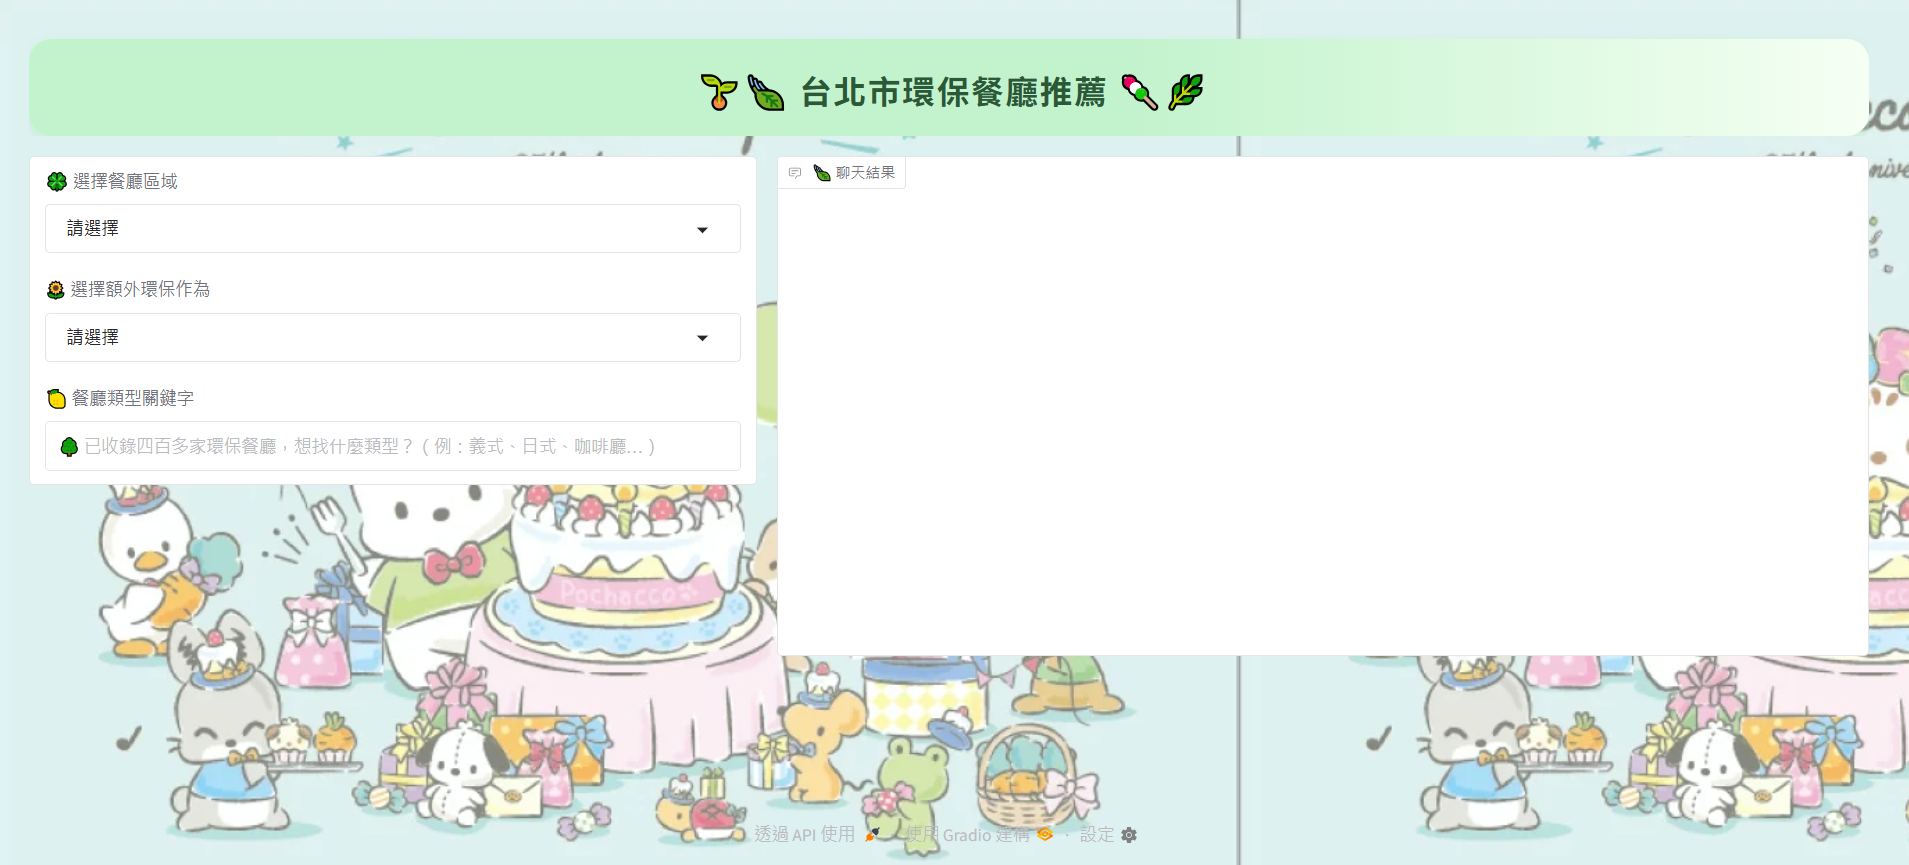

In [53]:
from IPython.display import Image, display

display(Image(filename='sample_data/interface.PNG', width=1400, height=600))

# **執行畫面**  
下拉選單可以選擇「餐廳區域」和「額外環保作為」  
有其他對於餐廳的需求也可以搜尋關鍵字

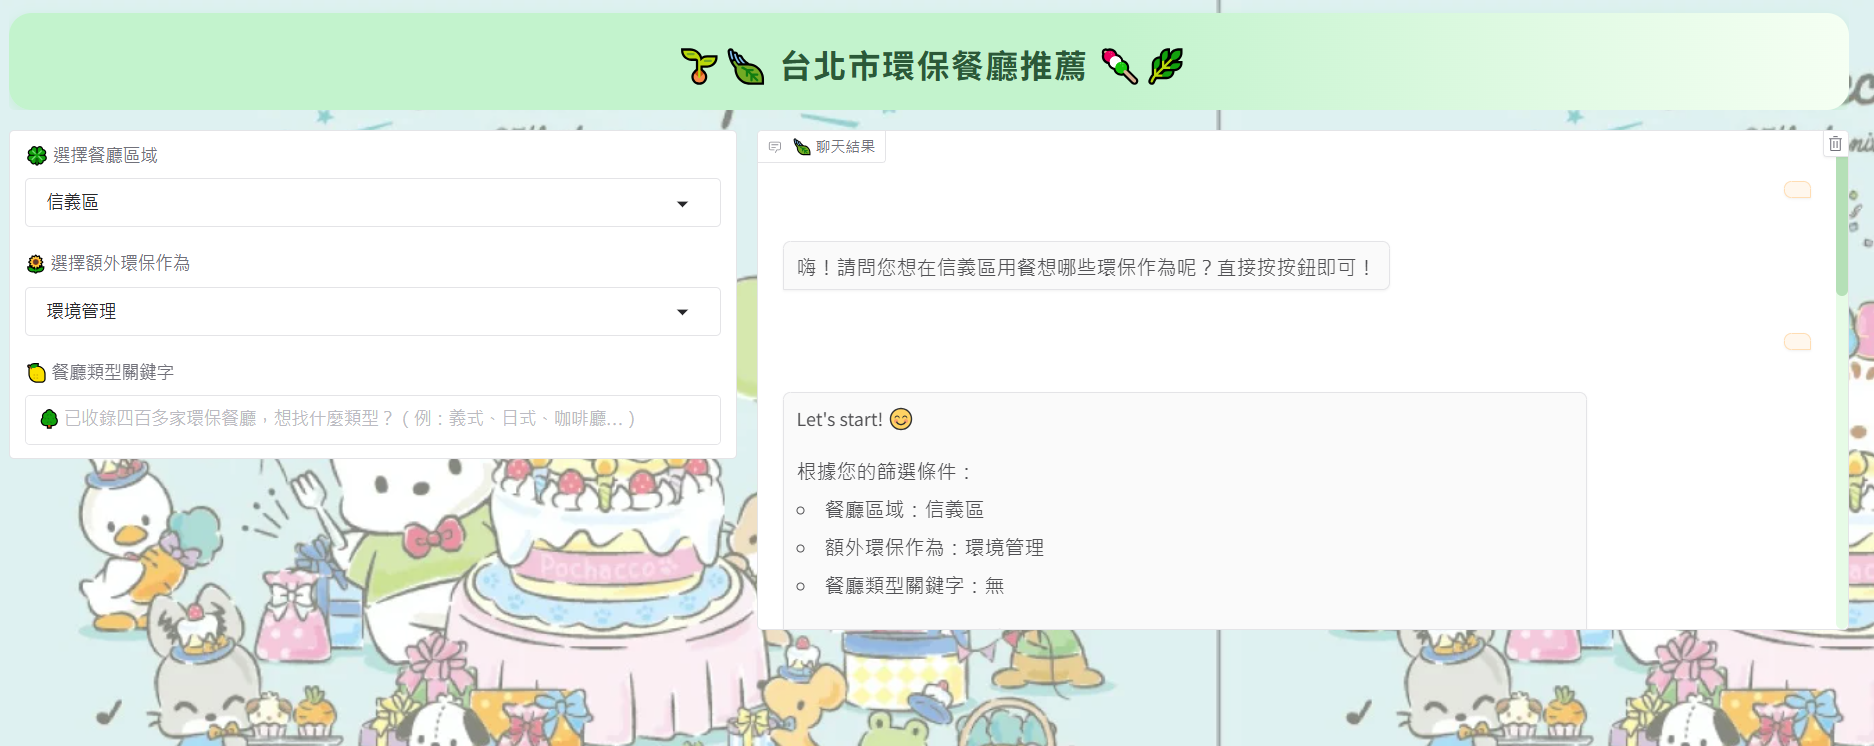

In [54]:
#首先用下拉式選單選擇「餐廳區域」和「額外環保作為」
from IPython.display import Image, display

display(Image(filename='sample_data/1.PNG', width=1400, height=600))

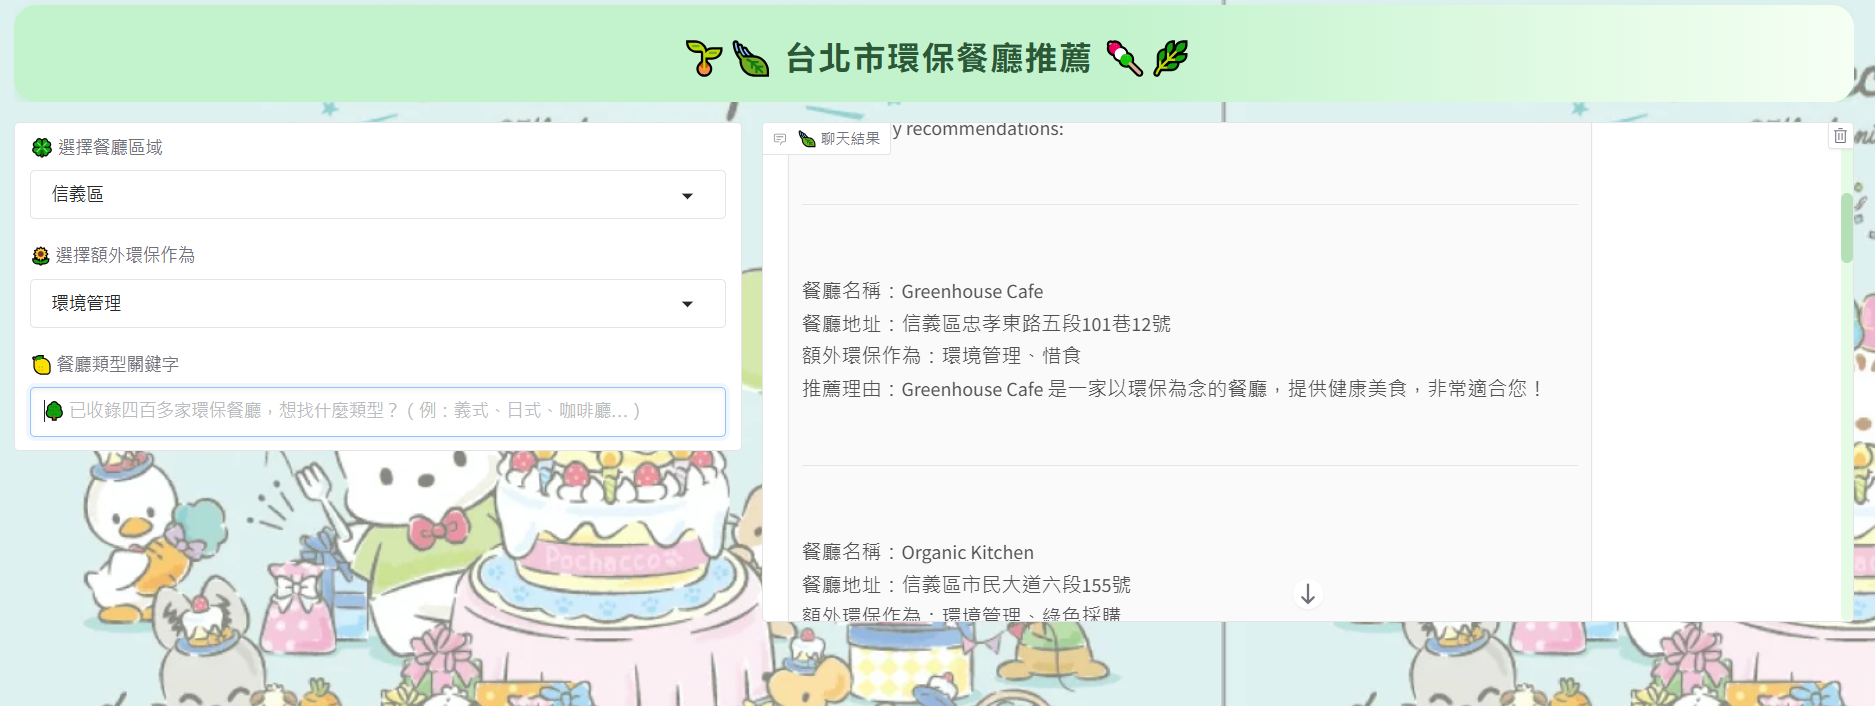

In [55]:
#會提供所有符合條件的餐廳的名稱和地址，以及自動生成的推薦理由
from IPython.display import Image, display

display(Image(filename='sample_data/1.1.PNG', width=1400, height=600))

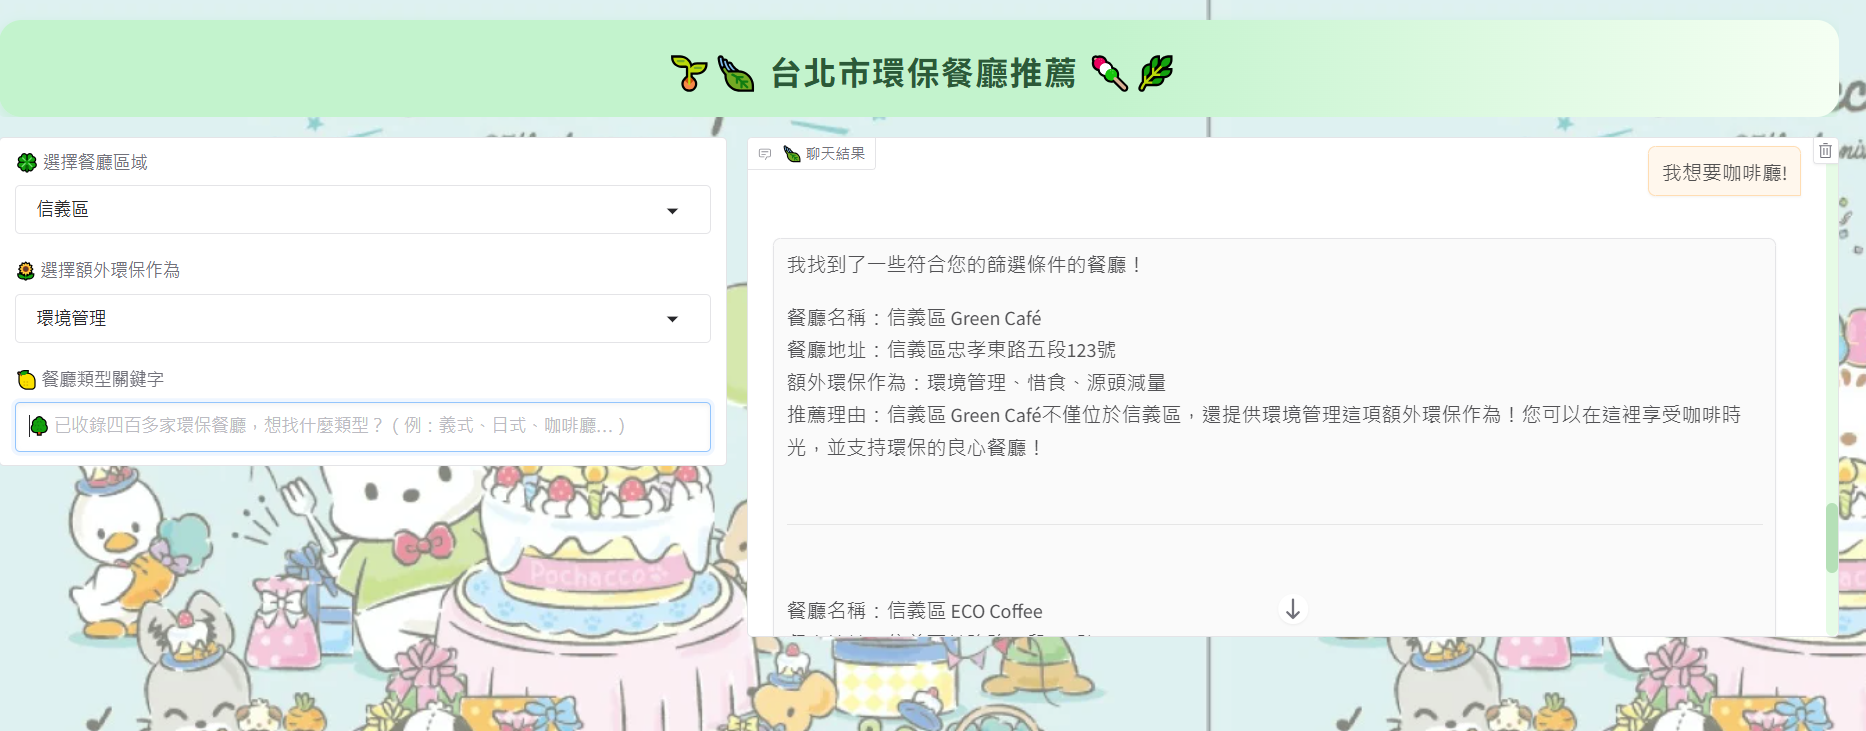

In [56]:
#手動輸入餐廳類型的關鍵字，會從上面的餐廳當中，篩選出符合條件的餐廳
from IPython.display import Image, display

display(Image(filename='sample_data/2.PNG', width=1400, height=600))

In [2]:
#1. 建立資料夾
import os
upload_dir = "uploaded_docs"
os.makedirs(upload_dir, exist_ok=True)
print(f"將檔案放到這個資料夾中： {upload_dir}")

將檔案放到這個資料夾中： uploaded_docs


In [3]:
#2. 更新套件並引入
!pip install -U langchain langchain-community pypdf python-docx sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.2/304.2 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12

In [4]:
from langchain_community.document_loaders import TextLoader, PyPDFLoader, UnstructuredWordDocumentLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

In [5]:
#3. 自訂支援 E5 的 embedding 模型（加上 "passage:" / "query:" 前綴）
from langchain.embeddings import HuggingFaceEmbeddings

class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

In [10]:
#4. 載入文件
folder_path = upload_dir
documents = []
for file in os.listdir(folder_path):
    path = os.path.join(folder_path, file)
    if file.endswith(".txt"):
        loader = TextLoader(path)
    elif file.endswith(".pdf"):
        loader = PyPDFLoader(path)
    elif file.endswith(".docx"):
        loader = UnstructuredWordDocumentLoader(path)
    else:
        continue
    documents.extend(loader.load())

In [11]:
#5. 建立向量資料庫
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = splitter.split_documents(documents)

In [12]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
vectorstore = FAISS.from_documents(split_docs, embedding_model)

In [13]:
#6. 儲存向量資料庫
vectorstore.save_local("faiss_db")

In [14]:
!zip -r faiss_db.zip faiss_db

  adding: faiss_db/ (stored 0%)
  adding: faiss_db/index.pkl (deflated 86%)
  adding: faiss_db/index.faiss (deflated 8%)


### 1. 安裝並引入必要套件

In [17]:
!pip install -U langchain langchain-community sentence-transformers faiss-cpu gradio openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.5/720.5 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 104.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.81.0
    Uninstalling openai-1.81.0:
      Successfully uninstalled openai-1.81.0


In [18]:
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationalRetrievalChain

In [19]:
from openai import OpenAI
import gradio as gr

### 2. 自訂 E5 embedding 類別

In [20]:
class CustomE5Embedding(HuggingFaceEmbeddings):
    def embed_documents(self, texts):
        texts = [f"passage: {t}" for t in texts]
        return super().embed_documents(texts)

    def embed_query(self, text):
        return super().embed_query(f"query: {text}")

### 3. 載入 `faiss_db`

In [21]:
embedding_model = CustomE5Embedding(model_name="intfloat/multilingual-e5-small")
db = FAISS.load_local("faiss_db", embedding_model, allow_dangerous_deserialization=True)
retriever = db.as_retriever()

### 4. 設定好我們要的 LLM

In [22]:
import os
from google.colab import userdata

In [23]:
api_key = userdata.get('Groq')

In [24]:
os.environ["OPENAI_API_KEY"] = api_key

這裡的模型和 `base_url` 是用 Groq

In [25]:
model = "llama3-70b-8192"
base_url="https://api.groq.com/openai/v1"

In [26]:
client = OpenAI(
    base_url=base_url # 使用 OpenAI 本身不需要這段
)

### 5. `prompt` 設計

In [40]:
system_prompt = """你是一位環保餐廳推薦員，總是用繁體中文回答，台灣慣用語，熱情親切。
每筆餐廳間有空行分隔，欄位以「欄位名稱: 欄位內容」方式呈現。
請根據資料，推薦使用者他們的可以去哪間餐廳。

使用者操作界面包含三種輸入方式：
1. 按鈕選擇「餐廳區域」（例：松山區、大安區、信義區⋯⋯）
2. 按鈕選擇「額外環保作為」（例：環境管理、綠色採購、惜食、源頭減量、節能減碳⋯⋯）
3. 自由文字輸入「餐廳類型」關鍵字（例：義式、日式、素食、咖啡廳⋯⋯）

你的任務：
優先使用按鈕傳來的篩選條件（若有）：
  - 若使用者選了「餐廳區域」，只考慮該區域內的資料。
  - 若使用者選了「額外環保作為」，只考慮含至少該項環保作為的資料。
  - 若兩者都選了，即同時滿足「區域」＋「環保作為」的條件。
- 如果使用者僅輸入餐廳類型關鍵字，未按任何按鈕，先親切詢問：「請問您想在哪個區域用餐？或想要哪些環保作為呢？直接按按鈕即可！」

-回答時必須包含：
  1. 推薦的「餐廳名稱」
  2. 該「餐廳區域」
  3. 「額外環保作為」有哪些（從 retrieved_chunks 裡讀出所有項目）
  4. 「類型標籤」：若使用者輸入了餐廳類型，請確認該餐廳屬於此類型或標註
  5. 「推薦理由」：一句兩句，具體說明為何推薦、建議的用餐時段或搭配方式


若資料不足，請以親切語氣回覆：「不好意思，目前資料中找不到符合【區域：X】【環保作為：Y】【類型：Z】的餐廳，請問是否還有其他偏好？」


如果使用者不知道要吃什麼，請以問句的形式詢問他們希望餐廳有哪些額外環保，並推薦對應的餐廳。請用台灣習慣的中文回應。"""

prompt_template = """

以下是後端檢索（RAG）回傳的餐廳資料片段，每筆之間以空行分隔，欄位格式為「欄位名稱: 欄位內容」，根據下列資料回答問題：

{retrieved_chunks}

使用者目前的篩選條件：
- 餐廳區域：{selected_region}
- 額外環保作為：{selected_eco}
- 餐廳類型關鍵字：{question}

請按以下流程回覆：

1. 如果「餐廳區域」與「額外環保作為」都是「無」且使用者未輸入任何文字，先以：「請問您想在哪個區域用餐？或想要該餐廳有哪些環保作為呢？」
2. 如果使用者只輸入「餐廳類型關鍵字」但未選任何按鈕，也先問：「請問想要哪個區域？或有哪些環保作為條件？直接按按鈕即可！」
3. 否則，根據篩選條件與 retrieved_chunks：
   - 尋找符合所有選項的 1～3 家餐廳。
   - 每家都要輸出：
     ```
     餐廳名稱：XXXX
     餐廳地址：XXXX
     額外環保作為：XXXX, XXXX, …
     推薦理由：ZZZZ（一句或兩句具體建議）
     ----
     ```
4. 最後用親切語氣補：「希望這些建議能幫助您找到滿意的環保餐廳！如果還有其他需求，再跟我說🥰」

如果找不到任何符合條件的餐廳，請回：「不好意思，目前資料中找不到符合條件的餐廳，請問是否可以再提供其他偏好？ 」
"""

### 6. 使用 RAG 來回應

搜尋與使用者問題相關的資訊，根據我們的 prompt 樣版去讓 LLM 回應。

In [41]:
chat_history = []

def chat_with_rag(user_input, selected_region, selected_eco):
    global chat_history

    # 7.1 從 FAISS 檢索相關 documents
    docs = retriever.get_relevant_documents(user_input)
    filtered_docs = []
    for doc in docs:
        meta = doc.metadata or {}
        region = meta.get('餐廳區域', '')
        eco_measures = meta.get('額外環保作為', '')
        # 區域篩選
        if selected_region and selected_region != "無" and region != selected_region:
            continue
        # 環保作為篩選
        if selected_eco and selected_eco != "無" and selected_eco not in eco_measures:
            continue
        filtered_docs.append(doc)
    docs = filtered_docs

    # 7.2 當三個條件都空（或都是「無」）時，先引導用戶
    if ((not selected_region or selected_region == "無") and
        (not selected_eco or selected_eco == "無") and
        not user_input.strip()):
        return "請問您想在哪個區域用餐？或想要該餐廳有哪些額外環保作為呢？直接按按鈕即可！"

    # 7.3 使用者只輸入文字，卻未選任何按鈕，也先引導
    if ((not selected_region or selected_region == "無") and
        (not selected_eco or selected_eco == "無") and
        user_input.strip()):
        return "請問想要哪個區域？或有哪些環保作為條件？直接按按鈕即可！"

    # 7.4 如果 docs 不為空，合併 retrieved_chunks，否則留空
    if docs:
        retrieved_chunks = "\n\n".join([doc.page_content for doc in docs])
    else:
        retrieved_chunks = ""

    # 7.5 把三個變數帶入 prompt_template
    final_prompt = prompt_template.format(
        retrieved_chunks=retrieved_chunks,
        selected_region=(selected_region if selected_region else "無"),
        selected_eco=(selected_eco if selected_eco else "無"),
        question=user_input
    )

    # 7.6 呼叫 LLM
    response = client.chat.completions.create(
        model="llama3-70b-8192",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": final_prompt},
        ]
    )
    answer = response.choices[0].message.content.strip()

    # 7.7 記錄聊天歷史並回傳
    chat_history.append((user_input, selected_region, selected_eco, answer))
    return answer

### 7. 用 Gradio 打造 Web App

In [42]:
custom_css = """
.gradio-container {
    background: url('https://www.niusnews.com/upload/imgs/default/202401_Noah/0115/1/pochacco9.jpg') repeat fixed,
                linear-gradient(135deg, #e0f8e6 0%, #a6e3c7 100%) !important;
    background-size: 1000px, cover !important;
}
h1, h2, h3 {
    font-family: 'Noto Sans TC', 'Cute Font', 'Arial Rounded MT Bold', 'Arial', sans-serif;
    color: #2b5938;
    background: linear-gradient(90deg, #c3f3cd 60%, #f5fff3 100%);
    border-radius: 18px;
    padding: 24px 10px 20px 16px;
    margin: 24px 0 14px 0;
    box-shadow: 0 4px 12px #b8ebc6a8;
    text-align: center;
    letter-spacing: 1.5px;
}
.gradio-dropdown, .gradio-textbox {
    border-radius: 14px !important;
    border: 1.8px solid #b5e0b7 !important;
    padding: 12px !important;
    font-size: 18px !important;
    background-color: #f6fcf4 !important;
    color: #235142 !important;
    box-shadow: 0 2px 7px #d2f2de38;
}
.gradio-chatbot {
    border-radius: 16px !important;
    border: 2px solid #a2d7b8 !important;
    background: linear-gradient(125deg, #ecfbf3 60%, #f4fff7 100%);
    padding: 14px !important;
    min-height: 340px;
    font-size: 17px !important;
}
.gradio-button {
    background: linear-gradient(90deg, #91dfb6 70%, #c8f2c1 100%) !important;
    color: #235142 !important;
    border-radius: 12px !important;
    font-size: 18px !important;
    border: none !important;
    font-weight: bold !important;
    box-shadow: 0 2px 8px #bddfc14a;
    transition: background 0.3s;
}
.gradio-button:hover {
    background: linear-gradient(90deg, #71d2a4 80%, #b2e9c0 100%) !important;
    color: #1d4934 !important;
}
.gradio-row { margin-bottom: 18px !important; }
::-webkit-scrollbar { background: #e6fbe6; width: 10px; border-radius: 16px;}
::-webkit-scrollbar-thumb { background: #b5e0b7; border-radius: 16px; }
"""

regions = ["請選擇", "松山區", "大安區", "信義區", "中山區", "中正區", "大同區", "萬華區", "文山區", "南港區", "內湖區", "士林區", "北投區"]
ecos = ["請選擇", "環境管理", "綠色採購", "惜食(善用食材)", "源頭減量", "節能減碳", "環境教育"]

with gr.Blocks(css=custom_css) as demo:
    gr.Markdown("<h1>🌱🍃 台北市環保餐廳推薦 🍡🌿</h1>")
    with gr.Row():
        with gr.Column(scale=2):
            reg = gr.Dropdown(regions, label="🍀 選擇餐廳區域", value="請選擇")
            eco = gr.Dropdown(ecos, label="🌻 選擇額外環保作為", value="請選擇")
            txt = gr.Textbox(
                placeholder="🌳 已收錄四百多家環保餐廳，想找什麼類型？（例：義式、日式、咖啡廳…）",
                label="🍋 餐廳類型關鍵字"
            )
        with gr.Column(scale=3):
            chat = gr.Chatbot(label="🍃 聊天結果")

    def respond(message, selected_region, selected_eco, history):
        ans = chat_with_rag(message, selected_region, selected_eco)
        history.append((message, ans))
        return "", history

    txt.submit(respond, [txt, reg, eco, chat], [txt, chat])
    reg.change(respond, [txt, reg, eco, chat], [txt, chat])
    eco.change(respond, [txt, reg, eco, chat], [txt, chat])

demo.launch()

<ipython-input-42-ab443d3fb2ba>:68: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chat = gr.Chatbot(label="🍃 聊天結果")


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a2395a81c9cde47225.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
